In [1]:
# In the notebook,  the performance under cifar10 will be test
import torch
from dataset import DatasetGenerator
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import utils

In [2]:
# Add Hook
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load('./model/PEMM_0911.pkl').to(device)
model.fc1.register_forward_hook(get_activation('fc1'))

In [4]:
dataset = DatasetGenerator(batchSize=64,
                               dataPath='../../datasets',
                               numOfWorkers=1,
                               noise_rate=0.4,
                               asym=False,
                               seed=123,
                               dataset_type='cifar10')
dataLoader = dataset.getDataLoader()

Files already downloaded and verified
20000 Noisy samples
Class 0, number of noisy  2000
Class 1, number of noisy  2000
Class 2, number of noisy  2000
Class 3, number of noisy  2000
Class 4, number of noisy  2000
Class 5, number of noisy  2000
Class 6, number of noisy  2000
Class 7, number of noisy  2000
Class 8, number of noisy  2000
Class 9, number of noisy  2000
20000
Print noisy label generation statistics:
Noisy class 0, has 4991 samples.
Noisy class 1, has 5026 samples.
Noisy class 2, has 4987 samples.
Noisy class 3, has 5025 samples.
Noisy class 4, has 5045 samples.
Noisy class 5, has 4962 samples.
Noisy class 6, has 4969 samples.
Noisy class 7, has 5050 samples.
Noisy class 8, has 4984 samples.
Noisy class 9, has 4961 samples.
Files already downloaded and verified
Num of train 50000
Num of test 10000


In [5]:
def get_flp(model_ft,data_loader,types):
    count = 0
    features = torch.empty((0,256))
    labels = torch.empty((0))
    preds = torch.empty((0))
    model_ft.eval()
    with torch.no_grad():
        for inputs, label in data_loader[types]:
            inputs = inputs.to(device)
            try:
                outputs = model_ft(inputs)
                _, pred = torch.max(outputs, 1)
            except:
                _,outputs = model_ft(inputs)
                _, pred = torch.max(outputs, 1)
                print(outputs[0])
            fea = activation['fc1']
#             print(inputs.shape)
            features  = torch.cat((features,fea.detach().clone().cpu()))
            labels = torch.cat((labels,label.detach().clone().cpu()))
            preds = torch.cat((preds,pred.detach().clone().cpu()))
            if count > 3000:
                break
            count = count + inputs.shape[0]
    return features,labels,preds

In [6]:
features,labels,preds = get_flp(model,dataLoader,"test_dataset")
# features_t,labels_t,preds_t = get_flp(model_ft,1)
features = preprocessing.StandardScaler().fit_transform(features)
print(np.mean(features))

/zijia/NLL/model.py:204: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554793803/work/torch/csrc/utils/python_arg_parser.cpp:1005.)
  dists.addmm_(1,-2,x,y.t())


tensor([-26.3334, -24.9236, -26.9973, -16.1047, -27.4632, -25.8686, -25.9814,
        -27.1832, -25.7655, -27.5808], device='cuda:0')
tensor([-14.4144, -14.9612, -13.2724,  -6.7487, -14.5170, -14.1545, -14.0043,
        -14.5376, -14.3694, -13.7907], device='cuda:0')
tensor([-18.5105, -17.7917, -17.4801, -17.6578, -18.3479, -17.6189,  -9.7890,
        -17.9622, -17.2758, -18.0276], device='cuda:0')
tensor([-17.7939, -17.4207, -17.3617, -15.4482, -16.8819,  -8.3044, -16.9347,
        -16.4000, -17.4964, -17.6004], device='cuda:0')
tensor([-16.6165, -17.0584, -17.3398, -10.8438, -17.1822, -11.3815, -16.8041,
        -15.5914, -17.1403, -17.3140], device='cuda:0')
tensor([-8.4396, -9.1499, -8.6171, -5.4319, -9.1827, -4.7522, -9.0524, -7.8222,
        -8.6811, -8.6900], device='cuda:0')
tensor([-12.0476, -11.4947, -10.5995,  -4.7967, -10.6266, -11.6853, -10.6713,
        -11.3573, -12.0674, -11.2862], device='cuda:0')
tensor([-8.3680, -8.0528, -9.5630, -9.6889, -9.6964, -9.6273, -9.3302, -

(3328, 256) torch.Size([3328])


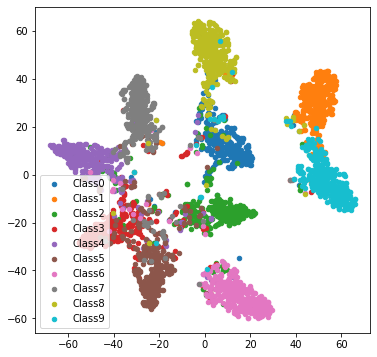

In [7]:
tsne = TSNE(learning_rate=200)
# w1 = model_ft.fc.centers.clone().detach().cpu()
# w1.requires_grad = False
# features = torch.cat((features,w1))
# features = features.clone().detach().cpu()
# label_centers = torch.tensor([0,1,2,3,4,5,6,7,8,9])
# labels = torch.cat((labels,label_centers))
plt.figure(figsize=(6,6))
print(features.shape,labels.shape)
out = tsne.fit_transform(features)
for i in range(10):
    indices = labels == i
    x, y = out[indices].T
    plt.scatter(x, y, label='Class'+str(i),s=20)
#     plt.scatter(x[-1], y[-1],  marker='x',s=169, linewidths=3,c='g' ) # 把 corlor 设置为空，通过edgecolors来控制颜色
plt.legend()
plt.show()

In [10]:
def sort_dataset(data, labels, num_classes=10, stack=False):
    """Sort dataset based on classes.
    
    Parameters:
        data (np.ndarray): data array
        labels (np.ndarray): one dimensional array of class labels
        num_classes (int): number of classes
        stack (bol): combine sorted data into one numpy array
    
    Return:
        sorted data (np.ndarray), sorted_labels (np.ndarray)

    """
    sorted_data = [[] for _ in range(num_classes)]
    for i, lbl in enumerate(labels):
        sorted_data[int(lbl.item())].append(data[i])
    sorted_data = [np.stack(class_data) for class_data in sorted_data]
    sorted_labels = [np.repeat(i, (len(sorted_data[i]))) for i in range(num_classes)]
    if stack:
        sorted_data = np.vstack(sorted_data)
        sorted_labels = np.hstack(sorted_labels)
    return sorted_data, sorted_labels


def plot_heatmap(features, labels):
    """Plot heatmap of cosine simliarity for all features. """
    num_classes = 10
    features_sort, _ = sort_dataset(features, labels, 
                            num_classes=num_classes, stack=False)
    features_sort_ = np.vstack(features_sort)
    sim_mat = np.abs(features_sort_ @ features_sort_.T)
    sim_mat = sim_mat/np.max(sim_mat)
    print(np.max(sim_mat))

    plt.rc('text', usetex=False)
#     plt.rcParams['font.family'] = 'serif'
#     plt.rcParams['font.serif'] = ['Times New Roman'] #+ plt.rcParams['font.serif']
    fig, ax = plt.subplots(figsize=(5, 5), sharey=True, sharex=True)
    im = ax.imshow(sim_mat, cmap='Blues')
#     fig.colorbar(im, pad=0.1, drawedges=0, ticks=[0, 0.5, 1])
    ax.set_xticks(np.linspace(0, features.shape[0], 6))
    ax.set_yticks(np.linspace(0, features.shape[0], 6))
    [tick.label.set_fontsize(8) for tick in ax.xaxis.get_major_ticks()] 
    [tick.label.set_fontsize(8) for tick in ax.yaxis.get_major_ticks()]
#     fig.tight_layout()

1.0


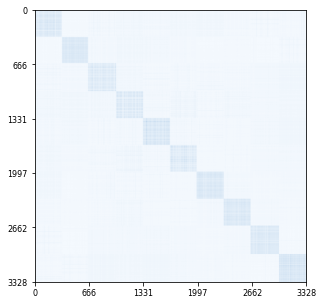

In [11]:
plot_heatmap(features,labels)